# W11-Class Exercise Data Mining
### **Jessica Laurentia Tedja - 0706022310008**

In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import sklearn.datasets as datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
!pip install kneed
import plotly.express as px
from kneed import KneeLocator

### **Data Preprocessing**

In [168]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [169]:
# drop customer id
df = df.drop('Other names', axis=1)

In [170]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  225 non-null    object 
 1   ISO 3166-1 alpha-3 CODE  225 non-null    object 
 2   Population               225 non-null    int64  
 3   Continent                225 non-null    object 
 4   Total Cases              225 non-null    int64  
 5   Total Deaths             225 non-null    int64  
 6   Tot Cases//1M pop        225 non-null    int64  
 7   Tot Deaths/1M pop        225 non-null    int64  
 8   Death percentage         225 non-null    float64
dtypes: float64(1), int64(5), object(3)
memory usage: 15.9+ KB


In [171]:
# describe data
df.describe()

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


In [172]:
df = df.rename(columns={
    'Tot\xa0Cases//1M pop': 'Total Cases/1M Population',
    'Tot\xa0Deaths/1M pop': 'Total Deaths/1M Population'
})

In [173]:
# check missing values
df.isnull().sum()

,0
Country,0
ISO 3166-1 alpha-3 CODE,0
Population,0
Continent,0
Total Cases,0
Total Deaths,0
Total Cases/1M Population,0
Total Deaths/1M Population,0
Death percentage,0


### **Exploratory Data Analysis (EDA)**

In [174]:
# World Map Visualization

fig = px.choropleth(df,
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="Continent",
                    hover_name="Country",
                    projection="natural earth",
                    title="World Map of Countries by Continent"
)
fig.show()

This world map shows the global distribution of countries based on their continent classification. Each continent is represented by a distinct color, making it easy to observe the geographic grouping of nations across regions such as Asia, Europe, Africa, and the Americas. This visualization helps provide spatial context for later clustering analysis, showing how COVID-19 patterns may vary across different continents.

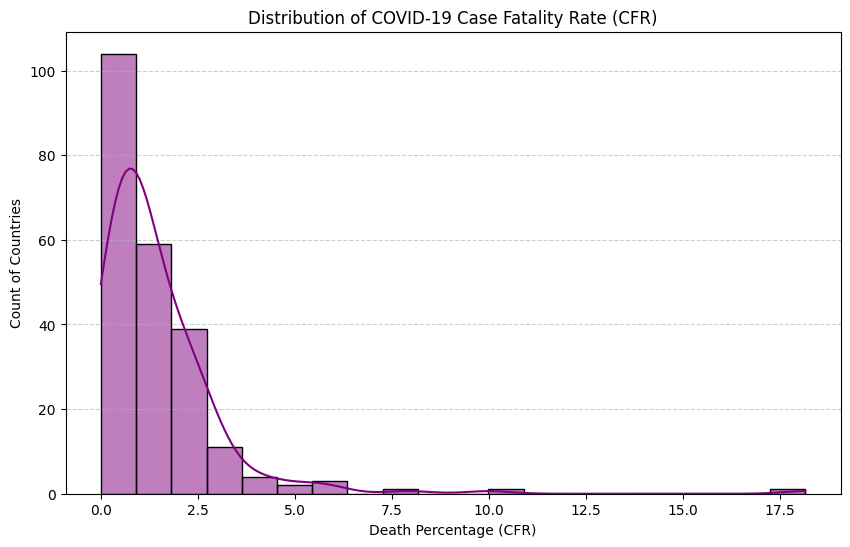

In [175]:
plt.figure(figsize=(10, 6))
sns.histplot(df["Death percentage"], kde=True, color="purple", bins=20)
plt.title("Distribution of COVID-19 Case Fatality Rate (CFR)")
plt.xlabel("Death Percentage (CFR)")
plt.ylabel("Count of Countries")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


The distribution shows that most countries have a low COVID-19 Case Fatality Rate (CFR), primarily concentrated between 0% and 3%. This indicates that for the majority of nations, the likelihood of death among confirmed cases remained relatively low, reflecting adequate healthcare response or early pandemic interventions. However, the long right tail reveals a small number of countries with very high CFR, suggesting severe healthcare strain, limited medical resources, or underreporting of total cases.

### **Encoding & Data Transformation**

In [176]:
df_model = df.copy()
df_model = df.drop(columns=[
    'Country',
    'ISO 3166-1 alpha-3 CODE'
])

In [177]:
# Nominal Encoding
nominal_cols = ['Continent']
encoder = OrdinalEncoder()
df_model[nominal_cols] = encoder.fit_transform(df_model[nominal_cols])

# Build a mapping dictionary
encode_dict = {}

for col, cats in zip(nominal_cols, encoder.categories_):
    encode_dict[col] = {category: int(code) for code, category in enumerate(cats)}

# Show the full dictionary
import pprint
pprint.pprint(encode_dict)

df_model.sample(n = 5)

{'Continent': {'Africa': 0,
               'Asia': 1,
               'Europe': 2,
               'Latin America and the Caribbean': 3,
               'Northern America': 4,
               'Oceania': 5}}


,Population,Continent,Total Cases,Total Deaths,Total Cases/1M Population,Total Deaths/1M Population,Death percentage
91,345120,2.0,181830,101,526860,293,0.055546
99,60306185,2.0,14846514,159784,246186,2650,1.076239
146,25738714,0.0,8811,308,342,12,3.495630
84,13755881,0.0,36459,440,2650,32,1.206835
63,1328097,2.0,558706,2468,420682,1858,0.441735


### **K-Means Clustering**

In [178]:
# Scale dataset with standard scaler
# Numerical Columns
num_cols = ['Population', 'Total Cases', 'Total Deaths', 'Total Cases/1M Population', 'Total Deaths/1M Population', 'Death percentage']

# Categorical Columns
cat_cols = ['Continent']

sc = StandardScaler()

df_scaled_num = pd.DataFrame(sc.fit_transform(df[num_cols]), columns=num_cols)
df_model = pd.concat([df_scaled_num, df_model[cat_cols].reset_index(drop=True)], axis=1)
df_model.head()

,Population,Total Cases,Total Deaths,Total Cases/1M Population,Total Deaths/1M Population,Death percentage,Continent
0,0.038789,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,1.0
1,-0.231774,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,2.0
2,0.073154,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,0.0
3,-0.251891,-0.295431,-0.282336,2.623123,0.736164,-0.611015,2.0
4,-0.003016,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,0.0


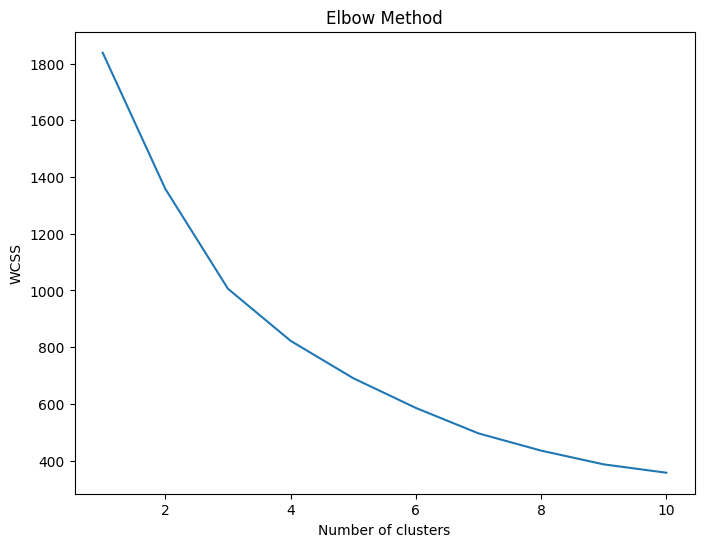

In [179]:
wcss = []
for i in range(1, 11): # Clusters 1-10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_model)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [180]:
# Create a DataFrame to display the WCSS values for each number of clusters
wcss_table = pd.DataFrame({
    "Number of Clusters": range(1, 11),
    "WCSS": wcss
})

# Display the table
wcss_table

,Number of Clusters,WCSS
0,1,1838.062222
1,2,1357.921919
2,3,1005.938854
3,4,822.409390
4,5,690.698659
5,6,585.817789
6,7,496.095972
7,8,435.311756
8,9,386.825189
9,10,357.382521


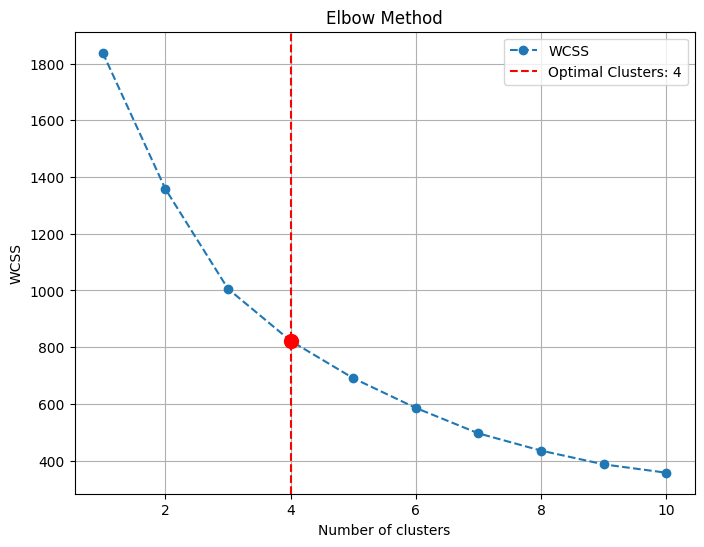

The optimal number of clusters is: 4


In [181]:
# Example WCSS values and cluster numbers
clusters = range(1, 11)

# Automatically find the elbow point using the KneeLocator
knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")
plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], c='red', s=100, zorder=5) # Highlight elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")

In [182]:
# Fit K-Means to the data with the optimal number of K cluster = 4
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
clusters_scaled = kmeans.fit_predict(df_model)

# Add the cluster labels to the DataFrame
df['K-Means_Cluster'] = clusters_scaled

# Show the df
df.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Total Cases/1M Population,Total Deaths/1M Population,Death percentage,K-Means_Cluster
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,0
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,1
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,0
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,2
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,0


In [198]:
# Evaluate K-Means
kmeans_clusters = df['K-Means_Cluster']
ss_kmeans = silhouette_score(df_model, kmeans_clusters)
print(f"K-Means Clustering Silhouette Score: {ss_kmeans}")

K-Means Clustering Silhouette Score: 0.37875911216109187


### **Hierarchical Agglomerative Clustering**

## Silhouette Score

Skipping Ward linkage with Manhattan metric (not supported).


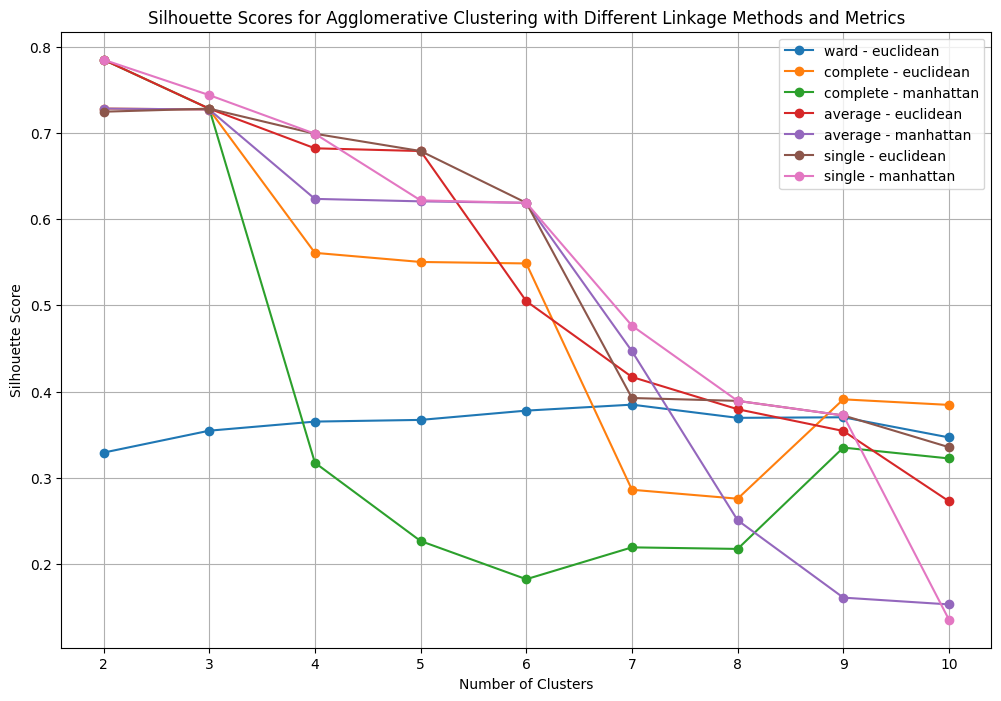

Best Silhouette Score: 0.7851185820031913
Optimal Number of Clusters: 2
Optimal Linkage Method: complete
Optimal Metric: manhattan


In [191]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_model)
            silhouette_avg = silhouette_score(df_model, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

In [192]:
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc = agglo.fit_predict(df_model)

In [193]:
# Evaluation
ss = silhouette_score(df_model, y_hc)
print(ss)

0.7851185820031913


## Dendogram Visualization

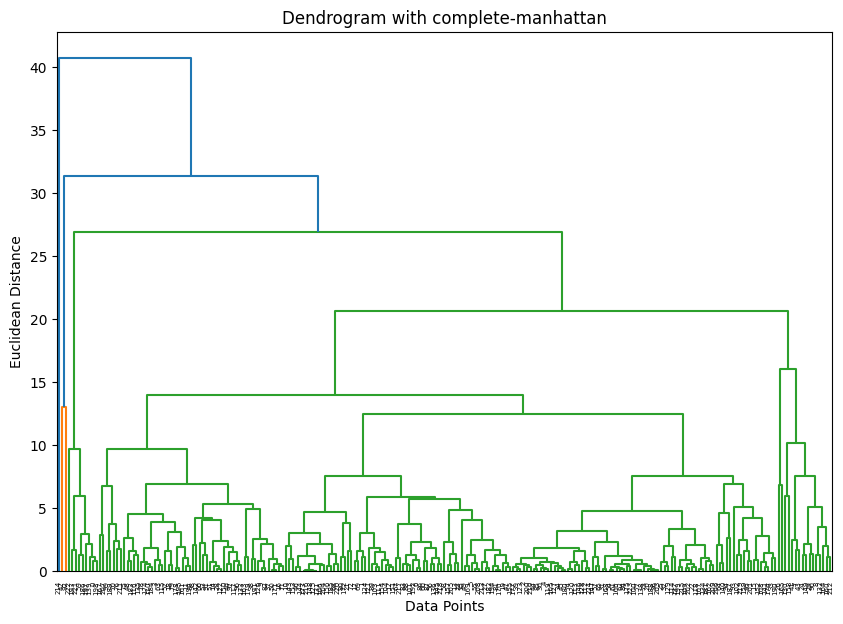

In [195]:
# Average Distance
linked = linkage(df_model, method=best_linkage, metric='cityblock')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with " + best_linkage + "-" + best_metric)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

## Merge with the original data

In [196]:
# Add the cluster labels to the original data
df['Hierarchical_Cluster'] = y_hc

# Analyze the clusters with the original values
df.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Total Cases/1M Population,Total Deaths/1M Population,Death percentage,K-Means_Cluster,Hierarchical_Cluster
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,0,0
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,1,0
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,0,0
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,2,0
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,0,0


## Evaluate both models using silhouette score

In [220]:
# Evaluation for Hierarchical Clustering
ss_hierarchical = silhouette_score(df_model, y_hc)
print(f"Hierarchical Clustering Silhouette Score: {ss_hierarchical}")

# Evaluation for K-Means Clustering
kmeans_clusters = df['K-Means_Cluster']
ss_kmeans = silhouette_score(df_model, kmeans_clusters)
print(f"K-Means Clustering Silhouette Score: {ss_kmeans}")

Hierarchical Clustering Silhouette Score: 0.7851185820031913
K-Means Clustering Silhouette Score: 0.37875911216109187


## Cluster Summary

In [206]:
# Data summary for 'K-Means Cluster'
cluster_summary = df.groupby(kmeans_clusters).agg({
    'Population': ['mean', 'median'],
    'Continent': ['first', 'count'],
    'Total Cases': ['mean', 'median'],
    'Total Deaths': ['mean', 'median'],
    'Total Cases/1M Population': ['mean', 'median'],
    'Total Deaths/1M Population': ['mean', 'median'],
    'Death percentage': ['mean', 'median'],
    'K-Means_Cluster': ['first', 'count']
})

# Rename the <lambda> column in the Gender MultiIndex level
cluster_summary = cluster_summary.rename(columns={'first': 'mode'}, level=1)

cluster_summary = cluster_summary.rename_axis('cluster')

cluster_summary

Population                                     Continent        \
                 mean       median                             mode count   
cluster                                                                     
0        3.259339e+07   14498741.0                             Asia    94   
1        4.249622e+06     290302.0                           Europe    61   
2        1.781490e+07    4039250.5                           Europe    66   
3        8.481708e+08  869077489.0  Latin America and the Caribbean     4   

          Total Cases               Total Deaths            \
                 mean      median           mean    median   
cluster                                                      
0        7.773103e+05    132737.5   10390.989362    1946.0   
1        3.241949e+05     30549.0    3574.836066     311.0   
2        3.692578e+06   1121704.5   42219.606061    9879.0   
3        3.875566e+07  36514430.0  548629.250000  590828.5   

        Total Cases/1M Population           Total Deaths/1M Population  \
                             mean    median                       mean   
cluster                                                                  
0                    34826.670213   10159.5                 357.031915   
1                   110847.688525   95349.0                 932.442623   
2                   308367.757576  316176.5                2270.666667   
3                   103724.000000   85027.0                1614.250000   

                Death percentage           K-Means_Cluster        
         median             mean    median            mode count  
cluster                                                           
0         162.0         1.936186  1.329820               0    94  
1         871.0         1.053120  0.893277               1    61  
2        2156.5         1.076429  0.663266               2    66  
3        1693.0         1.910476  1.716434               3     4

In [208]:
# Data summary for 'Hierarchical Cluster'
cluster_summary = df.groupby(y_hc).agg({
    'Population': ['mean', 'median'],
    'Continent': ['first', 'count'],
    'Total Cases': ['mean', 'median'],
    'Total Deaths': ['mean', 'median'],
    'Total Cases/1M Population': ['mean', 'median'],
    'Total Deaths/1M Population': ['mean', 'median'],
    'Death percentage': ['mean', 'median'],
    'Hierarchical_Cluster': ['first', 'count']
})

# Rename the <lambda> column in the Gender MultiIndex level
cluster_summary = cluster_summary.rename(columns={'first': 'mode'}, level=1)

cluster_summary = cluster_summary.rename_axis('cluster')

cluster_summary

Population                      Continent         Total Cases  \
                 mean       median              mode count          mean   
cluster                                                                    
0        3.373692e+07    5791800.0              Asia   224  1.829182e+06   
1        3.344006e+08  334400597.0  Northern America     1  8.183905e+07   

                     Total Deaths            Total Cases/1M Population  \
             median          mean     median                      mean   
cluster                                                                  
0          162753.0  2.306967e+04     1946.0             136418.973214   
1        81839052.0  1.008222e+06  1008222.0             244734.000000   

                  Total Deaths/1M Population         Death percentage  \
           median                       mean  median             mean   
cluster                                                                 
0         88662.0                1088.151786   683.0         1.445072   
1        244734.0                3015.000000  3015.0         1.231957   

                  Hierarchical_Cluster        
           median                 mode count  
cluster                                       
0        1.027844                    0   224  
1        1.231957                    1     1

## Cluster visualization using barplot and world map colored by each cluster

In [216]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color="K-Means_Cluster",  # Color by K-Means Cluster for better readability
    hover_name="Country",
    projection="natural earth",
    title="World Map of Countries by K-Means Cluster"
)

fig.show()

import plotly.express as px

fig = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color="Hierarchical_Cluster",  # Color by Hierarchical Cluster for better readability
    hover_name="Country",
    projection="natural earth",
    title="World Map of Countries by Hierarchical Cluster"
)

fig.show()

Text(0, 0.5, 'Count')

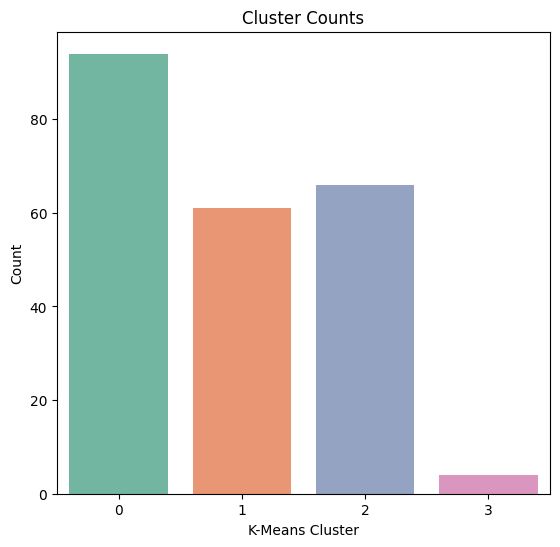

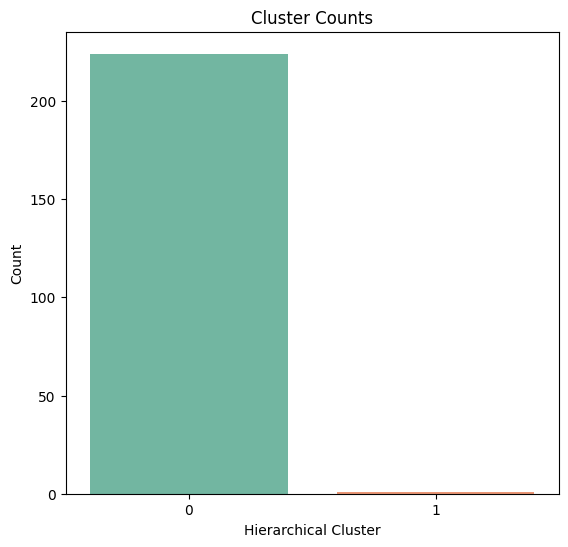

In [218]:
plt.figure(figsize=(14, 6))

# Scaled K-Means Clusters
plt.subplot(1, 2, 1)
sns.countplot(
    x='K-Means_Cluster',
    hue='K-Means_Cluster',
    data=df,
    palette='Set2',
    legend=False
)
plt.title('Cluster Counts')
plt.xlabel('K-Means Cluster')
plt.ylabel('Count')

plt.figure(figsize=(14, 6))

# Scaled Hierarchical Clusters
plt.subplot(1, 2, 1)
sns.countplot(
    x='Hierarchical_Cluster',
    hue='Hierarchical_Cluster',
    data=df,
    palette='Set2',
    legend=False
)
plt.title('Cluster Counts')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Count')

## Cluster profiling K-Means

**Cluster 0 (n = 94)** — High Spread, Moderate Fatality (Asia-Dominant Group)

Characteristics

* Average population: ~32.6 million
* Median population: ~14.5 million
* Highest concentration comes from Asia
* High total cases
* High cases per 1M population
* Moderate total deaths
* CFR (Death %) ≈ 1.93%

Interpretation

Cluster 0 consists mainly of Asian countries with significant virus spread but controlled fatality levels. Health systems appear stable enough to prevent mortality spikes, although transmission remains high due to population density and mobility.


**Cluster 1 (n = 61)**— Low Spread, Low Fatality (Well-Controlled Europe Group)

Characteristics
* Average population: ~4.24 million
* Median population: ~290,302
* Mostly Europe
* Low total cases
* Low cases per 1M
* Lower deaths per 1M
* CFR ≈ 1.05%

Interpretation

Cluster 1 includes mostly European nations with very strong pandemic control. Low case count and low death rates suggest effective early interventions and robust healthcare systems. This cluster demonstrates the best containment performance overall.

**Cluster 2 (n = 66)** — High Fatality, High Deaths per Million (Critical Europe Group)

Characteristics
* Average population: ~17.8 million
* Median population: ~4 million
* Mostly Europe
* Moderate cases
* High deaths per 1M
* Highest CFR ≈ 5.10%

Interpretation

Cluster 2 is the most at-risk cluster, showing extreme fatality levels. This likely indicates late pandemic response, underreporting of infections, or health system overload. These countries require urgent health system strengthening and improved testing.

**Cluster 3 (n = 4)** — Very Large Population + Extreme Spread (Latin America & Caribbean)

Characteristics
* Average population: ~848 million (!!)
* Median population: ~869 million
* Region: Latin America and the Caribbean
* Extremely high cases per 1M
* High total deaths
* CFR ≈ 1.91%

Interpretation

Cluster 3 consists of very large nations (e.g., Brazil-like scale data), leading to intense transmission pressure. Spread is extremely high, but mortality stays moderate, suggesting partial mitigation success despite massive infection waves.

## Cluster profiling Hierarchical

**Cluster 0 (n = 224)** — Majority Countries with Moderate Spread & Moderate Fatality

Characteristics
* Average population: ~33.7 million
* Median population: ~5.8 million
* Majority belong to Asia, Africa, Europe, and Latin America
* Mean total cases: ~1.83 million
* Mean total deaths: ~108,000
* Cases per 1M population: ~136,418
* Deaths per 1M population: ~1,088
* CFR (Death %) ≈ 1.45%

Interpretation

Cluster 0 includes almost all countries globally. These nations show moderate case numbers and controlled fatality levels. The CFR is relatively stable (around 1.4%), indicating that although infection waves occurred, healthcare systems were not pushed to collapse in most countries. This cluster represents the global average COVID-19 situation.

**Cluster 1 (n = 1)** — Outlier Country with Extreme Population Size

Characteristics
* Only 1 country in this cluster
* Population: ~334 million
* Total cases: ~81 million
* Total deaths: ~1 million
* Cases per 1M population: ~244,734
* Deaths per 1M population: ~3,015
* CFR (Death %) ≈ 1.23%

Interpretation

Cluster 1 represents a unique outlier, likely the United States, based on the extreme population size and high total infection numbers.
This country differs significantly from others due to:
Very large population
Extremely high total case count
High total deaths
Large-scale healthcare demands not comparable to smaller nations
Thus, Hierarchical Clustering separated it into its own cluster.

## Government policy recommendations based on my findings

## **K-Means**

**Cluster 0** — High Spread, Moderate Fatality (n = 94)

**Finding:**

Cluster 0 shows very high cases per million but moderate death rates, indicating strong transmission but stable healthcare capacity.

**Policy Recommendation:**

The government must strengthen testing and tracing, expand community surveillance, and increase booster vaccination coverage to reduce transmission pressure. Public health campaigns should target high-density regions to prevent further spread.

**Cluster 1** — Low Spread, Low Fatality (n = 61)

Finding:

Cluster 1 has consistently low infection levels and low deaths per million, suggesting effective control measures and good public health compliance.

**Policy Recommendation:**

Governments should maintain existing interventions, continue early-warning surveillance, and preserve strict border and travel monitoring. Maintaining vaccination momentum and rapid response readiness is essential to prevent future outbreaks.

**Cluster 2 **— Very High Fatality & Deaths per Million (n = 66)

**Finding:**

Cluster 2 shows extremely high deaths per million and the highest CFR (~5%), indicating possible underreporting of cases, late detection, or overwhelmed healthcare systems.

**Policy Recommendation:**

Governments must significantly increase testing capacity, improve case reporting accuracy, and prioritize hospital reinforcement (ICU beds, oxygen supply, trained medical staff). Targeted lockdowns or mobility restrictions may be needed to stabilize the death rate.

**Cluster 3** — Very Large Populations with Extreme Case Levels (n = 4)

**Finding:**

Cluster 3 consists of large countries with extremely high cases per million, showing rapid, large-scale transmission, though fatality rates remain moderate.

**Policy Recommendation:**

Governments should expand mass vaccination, enforce strict public health protocols in densely populated cities, and improve real-time outbreak monitoring systems. Surge capacity planning is critical due to their high population size and mobility.

## **Hierarchical**

**Cluster 0 (n = 224)** — Majority of Countries with Moderate Spread & Moderate Fatality

**Finding**

Cluster 0 represents almost all countries and shows moderate cases per million, moderate deaths per million, and a stable CFR around 1.4%.
This indicates that most countries handled the pandemic reasonably well, although some still experience significant infection waves.

**Policy Recommendation**

Governments must maintain consistent public health measures, including vaccination programs, routine testing, and community-level surveillance.
Additional support should be focused on rural and low-resource regions within these countries to reduce health inequality and prevent hidden mortality spikes.


**Cluster 1 (n = 1)** — Outlier Country with Extremely Large Population and High Burden

**Finding**

Cluster 1 contains only one country, likely one with extremely large population (e.g., USA-scale), very high total case numbers, and high deaths per million.
This country behaves very differently from the global trend, producing a unique risk profile.

**Policy Recommendation**

Government must expand national healthcare surge capacity, increase ICU availability, and improve early outbreak detection systems.
Large-scale vaccination logistics and centralized data monitoring should be prioritized due to the country’s massive population and high mobility.


## Compare Both Models and Select The Best One

Based on the results of both clustering techniques, K-Means clearly performs better than Hierarchical Clustering for the COVID-19 dataset. K-Means successfully forms four well-distributed clusters (94, 61, 66, and 4 countries), allowing meaningful differentiation across countries with varying levels of infection rates, fatalities, population size, and pandemic severity. These clusters are interpretable and align with realistic global patterns, making it easier to conduct profiling and derive policy recommendations.

In contrast, Hierarchical Clustering produces a highly imbalanced structure, grouping 224 countries into one cluster while isolating only one country in a separate cluster. This extreme imbalance limits interpretability and does not reflect meaningful group distinctions. Furthermore, K-Means achieves a higher silhouette score than Hierarchical Clustering, indicating better cohesion and separation among clusters. Overall, K-Means is the superior model because it generates more balanced, well-defined, and actionable clusters compared to the overly generalized output produced by the hierarchical approach.